<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/2020_03_Evaluation_Measures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation measures
Before starting to dig a little bit deeper into the network training process, let's learn more about some of the usual measures used to evaluate the performance of a machine learning model. 

The metrics employed depend on the type of problem we are facing. In this tutorial, we will present evaluation measures for classification, ranking and regression problems. 




## Keras metrics
Before explaining some of the used measures, let's see how we can use them in Keras.

Keras provides several evaluation measures that are already implemented ([available metrics in Keras](https://keras.io/metrics/)). These metrics are passed at run time, and when `model.fit` is called Keras automatically keeps track of the training (and validation if given) performance per epoch.

```
model.compile(metrics=['categorical_accuracy'...])
```
We can also evaluate the performance of a model in any given data by calling `model.evaluate`, where the model returns results in the form of `results=[mean_loss, metric_1, metric_2, etc...]`.

### Custom metrics

There are cases where we want to use a non-standard metric for evaluating our models. We can define any metrics in a function and pass it to the `compile` method. Following the custom metric example given in the [documentation](https://keras.io/metrics/), let's implement a custom metric for the Boston Housing Dataset. 

The problem we try to solve in the Boston Housing Dataset is estimating the median value of a certain house in the area of Boston, Massachusetts. The given data contains 13 features per data point, being "per capita crime rate by town", "average number of rooms per dwelling" or "pupil-teacher ratio by town" some of the available features. More information about the dataset is given [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

As an example of custom metric, we want to keep track of the mean predicted value during training, which we do in the below code cell.

57344/57026 [==============================] - 0s 0us/step


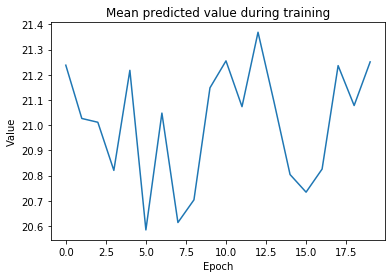

In [5]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.datasets import boston_housing

## This our custom metric
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(13,)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_absolute_error', metrics=[mean_pred])
history = model.fit(x_train, y_train, epochs=20, batch_size=32,  verbose = 0)
# Plot training accuracy values
plt.plot(history.history['mean_pred'])
plt.title('Mean predicted value during training')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.show()

# Classification
As we know, a classification model maps some input variable into one of the available output classes. The most used metric is the accuracy of the model, which is the ratio between the number of correct predictions and the total number of examples. The error rate, which is defined as $err.=1-acc.$ can also be used in some cases.

A related measure that is reported in some cases is the top-k accuracy, which takes the top-k classes predicted by the model and checks if the correct class is in any of those top-k predicted classes. An example of a dataset where it is usual to report the top-5 error is [ImageNet](image-net.org) as shown in [AlexNet's paper](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf).

Let's show a quick example of how to report the accuracy of a model in Keras. First, we prepare the MNIST dataset for training.




In [6]:
# importing some modules
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# network parameters
batch_size = 128
n_classes = 10
n_epochs = 12
img_rows, img_cols = 28, 28
n_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)

# import training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# reshape into matrices training and testing data
X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
X_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print('Number of training samples {:d}'.format(X_train.shape[0]))
print('Number of testing samples {:d}'.format(X_test.shape[0]))

# convert class vectors to binary class to use categorical_crossentropy as loss
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
      


11493376/11490434 [==============================] - 0s 0us/step
Number of training samples 60000
Number of testing samples 10000


Second, we define a small CNN architecture to classify digits. Notice how we give the metric `accuracy` when calling `compile`.



In [7]:
model_cnn = Sequential()

model_cnn.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1]),
                        padding='valid', input_shape=input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=pool_size))
model_cnn.add(Flatten())
model_cnn.add(Dense(n_classes))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                54090     
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
__________________________________________________

And now we train the network for 12 epochs.

In [8]:
history = model_cnn.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs,
          verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 3s 45us/step - loss: 0.3336 - acc: 0.9036 - val_loss: 0.1478 - val_acc: 0.9580
Epoch 2/12
60000/60000 [==============================] - 2s 37us/step - loss: 0.1226 - acc: 0.9659 - val_loss: 0.0903 - val_acc: 0.9745
Epoch 3/12
60000/60000 [==============================] - 2s 36us/step - loss: 0.0877 - acc: 0.9753 - val_loss: 0.0756 - val_acc: 0.9765
Epoch 4/12
60000/60000 [==============================] - 2s 36us/step - loss: 0.0719 - acc: 0.9801 - val_loss: 0.0685 - val_acc: 0.9798
Epoch 5/12
60000/60000 [==============================] - 2s 38us/step - loss: 0.0632 - acc: 0.9821 - val_loss: 0.0620 - val_acc: 0.9798
Epoch 6/12
60000/60000 [==============================] - 2s 35us/step - loss: 0.0574 - acc: 0.9837 - val_loss: 0.0568 - val_acc: 0.9816
Epoch 7/12
60000/60000 [==============================] - 2s 36us/step - loss: 0.0526 - acc: 0.9848 - val_loss: 0.0553 - val_acc

Finally, we evaluate the model in terms of score and accuracy. The returned metrics in Keras when using `evaluate` follow the format `score=[mean_loss_test, metric_1, metric_2, etc...]`, where `metric_n` are the metrics defined when compiling the model. In this case, we defined `accuracy`, hence we can retrieve the loss and accuracy of the model.

In [9]:
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss: {:f}'.format(score[0]))
print('Test accuracy: {:f}'.format(score[1]))

Test loss: 0.051283
Test accuracy: 0.982700


# Binary Classification

## ROC and AUC

In the previous example, our model has been evaluated using the accuracy measure, which calculates the mean accuracy rate across all predictions. 

In the binary classification case we can evaluate our model with more sophisticated evaluation metrics such as the [Receiver Operating Characteristic (ROC) curve or the Area Under the Curve (AUC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). To compute these metrics, we assume that we can apply in our classifier different discrimination thresholds, i.e. the threshold used to predict either positive or negative classes. ROC plots the True Positive Rate (ratio of actual positive elements predicted as positive) vs. the False Positive Rate (ratio of actual positive elements predicted as negative), and AUC summarizes the overall performance in a single number by computing the area under the ROC curve. AUC can be understood as the probability for a binary classifier to classify a randomly chosen positive sample higher than a randomly chosen negative sample. Although it may seem similar to measuring the classifier accuracy, it is a different measure. A way to highlight the difference between the two metrics is to consider a biased dataset with 90\% positive and 10\% negative classes. In that dataset, it is easy to achieve an accuracy of 90\%, as it only needs to always predict the element is positive. However, that same classifier would have a lower AUC. 

### Transforming our multiclass classification problem into several binary classification problems

As we mentioned, ROC and AUC are two metrics for evaluating the performance of a binary classifier. In that setting, we only need one ROC curve.

In case you want to measure the performance of a multiclass classifier, e.g. a classifier for the MNIST problem, we can use multiple ROC curves whose number depends on the number of classes. For example, evaluating a classifier trained on MNIST dataset requires 10 different ROC curves, each curve showing the ability of the model to distinguish a particular digit from all the others. This is typically known as one-versus-all setting.

We will use the MNIST dataset and the one-versus-all setting to compute a ROC curve and the corresponding AUC for both a non-CNN model and the CNN model we previously defined, showing that the latter is significantly better.



First, we define a model with only one intermediate layer and train it on MNIST.


In [10]:
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flat = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

x_train_flat = x_train_flat.astype('float32')
x_test_flat = x_test_flat.astype('float32')

x_train_flat /= 255
x_test_flat /= 255

y_train_c = np_utils.to_categorical(y_train, n_classes)
y_test_c = np_utils.to_categorical(y_test, n_classes)

# Load simple model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train_flat,y_train_c,batch_size=100, epochs=12,verbose=1,validation_data=(x_test_flat,y_test_c))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 2s 41us/step - loss: 0.7830 - acc: 0.7807 - val_loss: 0.3713 - val_acc: 0.8954
Epoch 2/12
60000/60000 [==============================] - 2s 39us/step - loss: 0.3459 - acc: 0.9018 - val_loss: 0.3016 - val_acc: 0.9147
Epoch 3/12
60000/60000 [==============================] - 2s 34us/step - loss: 0.3009 - acc: 0.9149 - val_loss: 0.2837 - val_acc: 0.9205
Epoch 4/12
60000/60000 [=============================

Next, we evaluate the performance of our simple model with the Keras evaluation method and compare it with the CNN-based model. You can notice the accuracy of fully-connected model is considerably lower.

In [11]:
score = model.evaluate(x_test_flat, y_test_c, verbose=1)
print('Test loss: {:f}'.format(score[0]))
print('Test accuracy: {:f}'.format(score[1]))

10000/10000 [==============================] - 0s 38us/step
Test loss: 0.244876
Test accuracy: 0.928600


Now, we will see in more detail how to compute the ROC and AUC for the multi-class classification problem.
The first step to do is predicting the category class for each sample of the testing set.

In [0]:
y_pred_cnn = model_cnn.predict(X_test)
y_pred = model.predict(x_test_flat)




In order to make these metrics work on a multiclass classifier, we need to rearrange a little bit our label and prediction data. 

For this purpose,  we define a function, `set_binary`, which takes as input a given positive class. The labels are transformed to either 1 (chosen positive label) or 0 (all the rest). We also return the confidence values indicating the probability that the corresponding sample is positive. 

In [0]:
def set_binary(y_pred, y_labels, positive_label):
  bin_y_pred, bin_y_labels = [], []

  for k, yl in enumerate(y_labels):
      if yl==positive_label:
        bin_y_labels.append(1)
      else:
        bin_y_labels.append(0)
      
      bin_y_pred.append(y_pred[k, positive_label])

  return [bin_y_pred, bin_y_labels]

After that, we import `roc_curve` and `auc` functions from `sklearn.metrics` module, which are two predefined functions for computing ROC and AUC.
In our example, we assume that the label `5` (which corresponds to the number `5` in MNIST) is the positive class, and compute ROC and AUC value for both the CNN and non-CNN model, showing that the CNN-based model works better.


In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
positive_label = 5
[bin_y_pred, bin_y_labels] = set_binary(y_pred, y_test, positive_label)
[bin_y_pred_cnn, bin_y_labels_cnn] = set_binary(y_pred_cnn, y_test, positive_label)


fpr_rf, tpr_rf, thresholds_rf = roc_curve(bin_y_labels, bin_y_pred)
fpr_rf_cnn, tpr_rf_cnn, thresholds_rf_cnn = roc_curve(bin_y_labels_cnn, bin_y_pred_cnn)

auc_keras = auc(fpr_rf,tpr_rf)
print(auc_keras)
auc_keras_cnn = auc(fpr_rf_cnn,tpr_rf_cnn)
print(auc_keras_cnn)


0.9930494012064494
0.9998937759344272


We finally plot the ROC curve for the 5-vs-all setting.

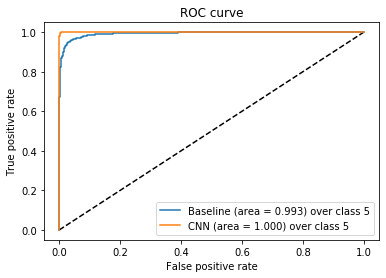

In [15]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Baseline (area = {:.3f}) over class 5'.format(auc_keras))
plt.plot(fpr_rf_cnn, tpr_rf_cnn, label='CNN (area = {:.3f}) over class 5'.format(auc_keras_cnn))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



# Retrieval
In a retrieval problem, given a query $q$ and a set of elements $D$, we aim to retrieve those elements from $D$ that are relevant for $q$.
## Precision and Recall

Precision and Recall are two widely used metrics used for retrieval problems. Precision is defined as the ratio of correct (or relevant) retrieved elements divided by the total number of retrieved elements. If a model retrieves $N$ elements from a query, and $k$ of those are correct, then $P=k/N$. Recall, which is the same as the previously introduced True Positive Rate, is the ratio of correct retrieved elements divided by the total number of correct elements in the dataset. If there are $M$ total relevant elements in $D$, the recall is $R=k/M$. There is usually a trade-off between precision and recall, which can be adjusted using a decision threshold in the measure used to retrieve the elements. For example, in the case where a query returns all of the possible elements in $D$, the recall would be 1 whereas the precision would typically be low. An in-depth explanation of both metrics is given in the corresponding [Wikipedia article](https://en.wikipedia.org/wiki/Precision_and_recall).


## MAP

Let's give a look now at Mean Average Precision (MAP), which is widely used in some problems such as [object detection](https://arxiv.org/abs/1506.01497) or [patch retrieval](https://arxiv.org/abs/1704.05939). Given a set of queries, MAP is the mean of the average precisions of all the queries. Now, what is the Average Precision (AP)? AP is defined as the area under the precision-recall curve, i.e.
$$
AP = \int_0^1 p(r)dr
$$
where $p(r)$ is the [precision-recall curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html). A more intuitive explanation can be found in [this blog](https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52).

Now, we will use the Fashion MNIST dataset, which is a little bit tougher than MNIST, for our retrieval example. We will first train the model in a standard classification setting. Then, we will take the intermediate features for each of the images in the test set, and we will use these features for our retrieval problem. Hence, for a query image $q$ from the test set, we retrieve its feature vector, and then retrieve the $k$ closest (using some defined distance, e.g. Euclidean) feature vectors from the test set. If the retrieved elements share the same class as $q$, we will consider it a true positive.

In [16]:
from keras.datasets import fashion_mnist
# importing some modules
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras

# the data, shuffled and split between train and test sets
img_rows, img_cols = 28, 28
n_classes= 10
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

4423680/4422102 [==============================] - 1s 0us/step


Second, we visualize some examples. Each grey-scale image contains an article of clothing, e.g. ankle boot, pullover, t-shirt.

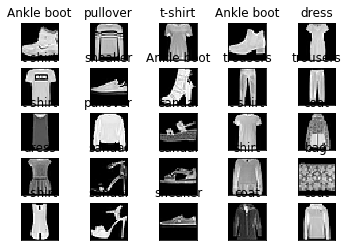

In [17]:
N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
items = ['t-shirt','trousers','pullover','dress','coat','sandal','shirt','sneaker','bag','Ankle boot']
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(X_train[idx, :, :, 0], cmap='gray')
    y_target = int(y_train[idx])
    target = items[y_target]
    axes[row,col].set_title(target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Third, we define a simple CNN architecture with few layers and train it on Fashion MNIST.

In [18]:
# network parameters
batch_size = 128
n_filters = 64
n_epochs = 12
img_rows, img_cols = 28, 28
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 1)
model_cnn = Sequential()

model_cnn.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1]),
                        padding='valid', input_shape=input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=pool_size))
model_cnn.add(Flatten())
model_cnn.add(Dense(n_filters))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(n_classes))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                692288    
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

In [19]:
history = model_cnn.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=1)

Epoch 1/12
60000/60000 [==============================] - 3s 52us/step - loss: 0.4462 - acc: 0.8433
Epoch 2/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.2966 - acc: 0.8937
Epoch 3/12
60000/60000 [==============================] - 3s 42us/step - loss: 0.2554 - acc: 0.9080
Epoch 4/12
60000/60000 [==============================] - 3s 45us/step - loss: 0.2286 - acc: 0.9174
Epoch 5/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.2060 - acc: 0.9261
Epoch 6/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.1889 - acc: 0.9313
Epoch 7/12
60000/60000 [==============================] - 3s 42us/step - loss: 0.1731 - acc: 0.9364
Epoch 8/12
60000/60000 [==============================] - 3s 43us/step - loss: 0.1568 - acc: 0.9429
Epoch 9/12
60000/60000 [==============================] - 3s 42us/step - loss: 0.1422 - acc: 0.9484
Epoch 10/12
60000/60000 [==============================] - 3s 44us/step - loss: 0.1292 - acc: 0.9533

Fourth, we extract the logits from the last fully connected layer and use them as the feature vectors for the retrieval task. The retrieval task is defined as follows: given a query, i.e. a specific article of clothing, we want to search for the most similar articles in the gallery and order all the gallery images in ascending order.

In [0]:
from keras import backend as K
extract_feature = K.function([model_cnn.layers[0].input],[model_cnn.layers[-4].output])
gallery_features = extract_feature([X_test[:20]])[0]
gallery_labels = y_test[:20]

probe_features = extract_feature([X_test[20:40]])[0]
probe_labels = y_test[20:40]

The method below computes mean average precision of the model over the probe (`test_codes, test_labels`) and gallery set (`learned_codes, y_train`) containing corresponding features and labels. This method is from [this blog](https://blog.sicara.com/keras-tutorial-content-based-image-retrieval-convolutional-denoising-autoencoder-dc91450cc511), following the link you can find further documentation about it. 

In [0]:
def compute_mean_average_precision(test_codes, test_labels, learned_codes, y_train, n_samples):
    # For each n_samples (=number of retrieved images to assess) we store the corresponding labels and distances
    out_labels = []
    out_distances = []
    ranks = np.zeros(n_samples)
    
    #For each query image feature we compute the closest images from training dataset
    for i in range(len(test_codes)):
        distances = []
        # Compute the euclidian distance for each feature from training dataset
        for code in learned_codes:
            distance = np.linalg.norm(code - test_codes[i])
            distances.append(distance)
        
        # Store the computed distances and corresponding labels from training dataset
        distances = np.array(distances)
      
        
        # Scoring function needs to replace similar labels by 1 and different ones by 0
        labels = np.copy(y_train).astype('float32')
        labels[labels != test_labels[i]] = -1
        labels[labels == test_labels[i]] = 1
        labels[labels == -1] = 0
        distance_with_labels = np.stack((distances, labels), axis=-1)
        sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]
        
        # The distances are between 0 and 28. The lesser the distance the bigger the relevance score should be
        sorted_distances = 1 - sorted_distance_with_labels[:, 0]
        sorted_labels = sorted_distance_with_labels[:, 1]
        ranks[np.where(sorted_labels==1)]=ranks[ np.where(sorted_labels==1)]+1
        
        # We keep only n_samples closest elements from the images retrieved
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])


    out_labels = np.array(out_labels)
    out_distances = np.array(out_distances)
    ranks=np.cumsum(ranks)/np.sum(ranks)
    
    # Score the model based on n_samples first images retrieved
    score = label_ranking_average_precision_score(out_labels, out_distances)
    return score,ranks

Finally, we are able to compute the MAP.

In [22]:
from sklearn.metrics import label_ranking_average_precision_score

# Compute score
score,ranks = compute_mean_average_precision(probe_features, probe_labels, gallery_features, gallery_labels, 20)
print("Mean Average Precision is {}".format(score))

Mean Average Precision is 0.6758928571428571


# Regression
Now we will quickly present some of the metrics used in regression problems, i.e. when you are estimating a continuous value $\hat{y}$. In these kind of problems, the usual metrics are the widely known Mean Absolute Error (MAE) and Mean Squared Error (MSE), defined as:

$$
MAE = \frac{1}{n} \sum_n |\hat{y} - y| \\
MSE = \frac{1}{n} \sum_n (\hat{y} - y)^2
$$



Other metrics used in some problems, e.g. [depth estimation](http://www.cvlibs.net/datasets/kitti/eval_depth.php?benchmark=depth_prediction), are the relative versions of MAE and MSE, which are called Mean Absolute Percentage Error (MAPE) and Mean Squared Percentage Error (MSPE).
$$
MAPE = \frac{100}{n} \sum_n \frac{|\hat{y} - y|}{|y|} \\
MSPE = \frac{100}{n} \sum_n \frac{(\hat{y} - y)^2}{|y|}
$$


# Coursework


### Task 1: Classification Evaluation Measures
Similarly to what we showed for the case of 5 vs. all in MNIST, train the same CNN and baseline model for CIFAR-10. Use the code given to train the models.

**Report**:
*   Report total accuracy and accuracy per class in the test split and training split.
*   Plot the ROC and AUC for both models for the class cat vs. all in the test split. The class *cat* corresponds to the label `3` in the dataset.

In [23]:
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils

# network parameters
batch_size = 128
n_classes = 10
n_epochs = 12
img_rows, img_cols = 32, 32
n_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)
 
# import training and testing data
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
# reshape into matrices training and testing data

input_shape = (img_rows, img_cols, 3)

X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_test /= 255


# convert class vectors to binary class matrices for efficiency reasons
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

### Baseline model
x_train_flat = X_train.reshape(x_train.shape[0], 3 * x_train.shape[1] * x_train.shape[2])
x_test_flat = X_test.reshape(x_test.shape[0], 3 * x_test.shape[1] * x_test.shape[2])

model_base = Sequential()
model_base.add(Dense(10, activation='relu', input_shape=x_train_flat.shape[1:]))
model_base.add(Dense(n_classes, activation='softmax'))

model_base.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model_base.fit(x_train_flat, Y_train, batch_size=batch_size, epochs=n_epochs,
          verbose=1, validation_data=(x_test_flat, Y_test))

### CNN
model_cnn = Sequential()

model_cnn.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1]),
                        padding='valid', input_shape=input_shape, data_format = 'channels_first'))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=pool_size))
model_cnn.add(Flatten())
model_cnn.add(Dense(n_classes))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model_cnn.fit(X_train, Y_train, batch_size=batch_size,epochs=n_epochs,
          verbose=1, validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 2s 41us/step - loss: 2.3035 - acc: 0.0969 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/12
50000/50000 [==============================] - 2s 35us/step - loss: 2.3027 - acc: 0.0990 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/12
50000/50000 [==============================] - 2s 34us/step - loss: 2.3027 - acc: 0.0970 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/12
50000/50000 [==============================] - 2s 33us/step - loss: 2.3027 - acc: 0.0978 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/12
50000/50000 [==============================] - 2s 34us/step - loss: 2.3027 - acc: 0.0981 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/12
50000/50000 [==============================] - 2s 35us/step - loss: 2.3027 - acc: 0.0963 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/12
50000/50000 [==============================] - 2s 36us/step - loss: 2.3027 - acc: 0.0973 - val_loss: 2.3026 - val_acc

### Task 2: Retrieval Evaluation Measures
In this exercise we will use the first 100 images of the test set of CIFAR10 as the query set $Q$ and the rest as the gallery.


In [24]:
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils

# network parameters
batch_size = 128
n_classes = 10
n_epochs = 12
img_rows, img_cols = 32, 32
n_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)
 
# import training and testing data
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
# reshape into matrices training and testing data

input_shape = (img_rows, img_cols, 3)

X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_test /= 255

print(x_train.shape)

y_train_c = to_categorical(y_train, n_classes)
y_test_c = to_categorical(y_test, n_classes)


model_cnn = Sequential()

model_cnn.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1]),
                        padding='valid', input_shape=input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=pool_size))
model_cnn.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1]),
                        padding='valid'))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=pool_size))
model_cnn.add(Flatten())
model_cnn.add(Dense(128))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(n_classes))
model_cnn.add(Activation('softmax'))


model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_cnn.summary()

history = model_cnn.fit(X_train, y_train_c, batch_size=batch_size,epochs=n_epochs,
          verbose=1, validation_data=(X_test, y_test_c))


## Setting up the gallery and queries
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

gallery_images = X_test[100:]
gallery_labels = y_test[100:]
from keras import backend as K
extract_feature = K.function([model_cnn.layers[0].input],[model_cnn.layers[-4].output])
gallery_features = extract_feature([X_test[100:,:,:]])[0]


query_images = X_test[:100]
query_labels = y_test[:100]
query_features = extract_feature([X_test[:100,:,:]])[0]



(50000, 32, 32, 3)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None


Use the piece of code given above to train a CNN in CIFAR 10. Then use the distance between the features from the CNN for ranking images as it was done in this tutorial. Taking the features extracted from the query $q$ (given in the `query_feature`) rank the gallery images by feature distance. Do not modify the network/hyperparameters for the training process.  

**Report**
*   Take the first image (`query_images[0]`) from the query set, which should have label `3`. Compute the precision-recall curve over the whole gallery for that first image.
*   Compute the Average Precision for the same first image, and then report the Mean Average Precision in all of the test queries from $Q$.
*   Count how many images with `label==3` are in the gallery. Assuming that we want to retrieve instances with`label==3`, report the ideal recall for the top 1000 retrieved images by a model that would always ranks the images from the correct class at the top.
*   Report the precision and recall for the top 1000 retrieved images with the trained model when using `query_images[0]`.





### Task 3: Regression Evaluation Measures


In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
model_mae = Sequential()
model_mae.add(Dense(100, activation='relu', input_shape=(13,)))
model_mae.add(Dense(1))
model_mae.compile(optimizer='adam',loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mae.fit(x_train, y_train, epochs=50, batch_size=32, verbose=0)
results = model_mae.evaluate(x_test, y_test)


102/102 [==============================] - 0s 2ms/step


As mentioned in the tutorial, the metrics MAE and MSE are given in the results variable in the format `results=[mean_loss_test, metric_1, metric_2, etc...]`. For this exercise implement the MAPE and MSPE as custom metrics.

**Report**
*   For the given network, report MAE, MSE, MAPE and MSPE  obtained on the test set.
*   Separate the values of `y_test` into bins of size 5, plot in a bar figure the MAE and MAPE for those bins. Thus we report the values of MAE and MAPE for the elements of `y_test` between 5-10, and between 10-15, and so on. Discuss the difference between the metrics.